In [3]:
import json
import pandas as pd
import statistics as stats
import re
import pprint

In [4]:
ALL_SEQUENTIAL_DATASETS = ["taxi", "nasdaq", "pums"]

ALL_SEQUENTIAL_MODELS = {
    "gretel": ["dgan"],
    "sdv": ["par"]
}

In [5]:
ERROR_VAL  = -99
def get_scores_df(exp_dataset, models_list, case="tabular", all_jobs=False):
    
    final_report = {
        "dataset": [], 
        "model": [],
        "case": [], 
        "domain_cov": [], 
        "stats_cov": [], 
        "outliers_cov": [],
        "missing_cov": [],
        "ks_sim": [], 
        "tv_sim": [],
        "corr_sim": [], 
        "contin_sim": [], 
        "sdv_quality_report": [],
        "wass_dist": [], 
        "js_dist": [], 
        "new_row_synthesis": []
    }


    for lib, models in models_list.items():
        
        if case == "hpo" and lib!= "syn":
            continue
        for model in models: 
            
            if case in ["hyperimpute", "ice", "missforest", "simple", "only_hyperimpute", "only_ice", "only_missforest", "only_simple",]:  
                corr_file = f"../metrics_out/hyperimpute/{model}_{lib}/{exp_dataset}/{case}/{exp_dataset}_{model}_correlation.csv"
                metrics_file = f"../metrics_out/hyperimpute/{model}_{lib}/{exp_dataset}/{case}/{exp_dataset}_{model}_metrics.json"
            else:
                corr_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_correlation.csv"
                metrics_file = f"../metrics_out/{case}/{model}_{lib}/{exp_dataset}/{exp_dataset}_{model}_metrics.json"
                        
            try:
                with open(metrics_file, 'r') as file:
                    metrics_scores = json.load(file)
                corr_df = pd.read_csv(corr_file)
                # print("Success:", metrics_file)
            except Exception as e:
                # print(e)
                if all_jobs:
                    # print(model, lib)
                    status = None
                    if lib in TABULAR_INCOMPLETE_JOBS and model in TABULAR_INCOMPLETE_JOBS[lib]:
                        if exp_dataset in TABULAR_INCOMPLETE_JOBS[lib][model]:
                            # print("Status: ",  TABULAR_INCOMPLETE_JOBS[lib][model][exp_dataset])
                            # print("-")
                            status = TABULAR_INCOMPLETE_JOBS[lib][model][exp_dataset]
                        else:
                            status = -99 #"Skipped"
                    else:
                        status =  -99 #"Skipped"
                        # print(e)
                        # print("Skipped")
                    for k in final_report.keys():
                        if k not in ["model", "dataset", "case"]: 
                            final_report[k].append(ERROR_VAL) #.append(status)
                        # print(final_report)
                    
                continue
            
            final_report["model"].append(f"{model}_{lib}")
            final_report["dataset"].append(exp_dataset)
            final_report["case"].append(case)
            
            #----------------------
            # Domain Coverage
            #----------------------
            if metrics_scores["coverage"]["domain_coverage"].values():
                domain_coverage_mean = round(stats.mean(metrics_scores["coverage"]["domain_coverage"].values()), 2)
                final_report["domain_cov"].append(domain_coverage_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["domain_cov"].append(ERROR_VAL)  # or any other default value

            #----------------------
            # Missing values Coverage
            #----------------------
            if metrics_scores["coverage"]["missing_values_coverage"].values():
                missing_values_coverage_mean = round(stats.mean(metrics_scores["coverage"]["missing_values_coverage"].values()), 2)
                final_report["missing_cov"].append(missing_values_coverage_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["missing_cov"].append(ERROR_VAL)  # or any other default value

            #----------------------
            # Outliers Coverage
            #----------------------
            if metrics_scores["coverage"]["outlier_coverage"].values():
                outlier_coverage_mean = round(stats.mean(metrics_scores["coverage"]["outlier_coverage"].values()), 2)
                final_report["outliers_cov"].append(outlier_coverage_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["outliers_cov"].append(ERROR_VAL)  # or any other default value
            
            #----------------------
            # Statistics Similarity
            #----------------------
            # Initialize total and count variables
            total_average = 0
            count = 0
            # Calculate the average of mean, median, and std for each column
            try:
                for c, s in metrics_scores["similarity"]["statistic"].items():
                    column_average = (s["mean"] + s["median"] + s["std"]) / 3
                    total_average += column_average
                    count += 1
                # Calculate the overall average
                overall_average = total_average / count if count > 0 else ERROR_VAL
                final_report["stats_cov"].append(round(overall_average, 2))
            except:
                final_report["stats_cov"].append(ERROR_VAL)

            #---------------------------
            # KSComplement & TVComplement
            #---------------------------
            ks_scores = []
            tv_scores = []
            for key, value in metrics_scores["sdv_quality_report"]["distribution"].items():
                if value["metric"] == "KSComplement":
                    ks_scores.append(value["score"])
                elif value["metric"] == "TVComplement":
                    tv_scores.append(value["score"])

            # Calculating averages
            ks_average = stats.mean(ks_scores) if ks_scores else ERROR_VAL
            tv_average = stats.mean(tv_scores) if tv_scores else ERROR_VAL
            final_report["ks_sim"].append(round(ks_average, 2))
            final_report["tv_sim"].append(round(tv_average, 2))

            #--------------------------------------------
            # contingency_average, correlation_average
            #--------------------------------------------
            contingency_average = corr_df[corr_df['Metric'] == 'ContingencySimilarity']["Score"].mean()
            correlation_average = corr_df[corr_df['Metric'] == 'CorrelationSimilarity']["Score"].mean()

            final_report["contin_sim"].append(round(contingency_average, 2))
            final_report["corr_sim"].append(round(correlation_average, 2))

            #--------------------------------------------
            # SDV quality report
            #--------------------------------------------
            final_report["sdv_quality_report"].append(round(metrics_scores["sdv_quality_report"]["score"], 2))
            
            #--------------------------------------------
            # Jensen Shannon Distance
            #--------------------------------------------
            if metrics_scores["similarity"]["js_distance"].values():
                js_dist_mean = round(stats.mean(metrics_scores["similarity"]["js_distance"].values()), 2)
                final_report["js_dist"].append(js_dist_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["js_dist"].append(ERROR_VAL)  # or any other default value
                
            #--------------------------------------------
            # Wassertein Distance
            #--------------------------------------------
            if metrics_scores["similarity"]["wass_distance"].values():
                wass_dist_mean = round(stats.mean(metrics_scores["similarity"]["wass_distance"].values()), 2)
                final_report["wass_dist"].append(wass_dist_mean)
            else:
                # Handle the case for empty list, e.g., append a default value or skip
                final_report["wass_dist"].append(ERROR_VAL)  # or any other default value

            #--------------------------------------------
            # Privacy: New row synthesis
            #--------------------------------------------
            if "score" in metrics_scores["privacy"]["new_row_synthesis"]:
                final_report["new_row_synthesis"].append(round(metrics_scores["privacy"]["new_row_synthesis"]["score"], 2))
            else:
                final_report["new_row_synthesis"].append(ERROR_VAL)
            
    return final_report

In [7]:
ORANGE = "#FFB347"
GREEN = "#77dd77"
YELLOW = "#fdfd96"

def highlight_top3_min3(s, skip_cols, min_cols, dummy_val=-99):
    '''
    Highlight the top 3 unique numerical values in each column with different colors.
    Highlight the smallest 3 unique values in specified columns.
    Skip specified columns and a specific dummy value.
    '''
    # Filter out the dummy value
    filtered_s = s[s != dummy_val]

    if s.name in min_cols:
        # Find the smallest 3 unique values for specified columns
        unique_bottom_values = filtered_s.drop_duplicates().nsmallest(3)
        return [f'background-color: {GREEN}' if v == unique_bottom_values.iloc[0] else
                f'background-color: {ORANGE}' if v == unique_bottom_values.iloc[1] else
                f'background-color: {YELLOW}' if v == unique_bottom_values.iloc[2] else ''
                for v in s]
    elif s.name not in skip_cols:
        # Find the top 3 unique values for other columns
        unique_top_values = filtered_s.drop_duplicates().nlargest(3)
        return [f'background-color: {GREEN}' if v == unique_top_values.iloc[0] else
                f'background-color: {ORANGE}' if v == unique_top_values.iloc[1] else
                f'background-color: {YELLOW}' if v == unique_top_values.iloc[2] else ''
                for v in s]
    else:
        return ['' for _ in s]  # Return empty styling for skipped columns


In [6]:
#TODO: pums-dgan is running 
seq_df = pd.DataFrame()
for exp_dataset in ALL_SEQUENTIAL_DATASETS:
    final_report = get_scores_df(exp_dataset, ALL_SEQUENTIAL_MODELS, "sequential", False)
    seq_df = pd.concat([seq_df, pd.DataFrame(final_report)], ignore_index=True)
seq_df 

,dataset,model,case,domain_cov,stats_cov,outliers_cov,missing_cov,ks_sim,tv_sim,corr_sim,contin_sim,sdv_quality_report,wass_dist,js_dist,new_row_synthesis
0,taxi,dgan_gretel,sequential,NaN,-99.00,0.17,0.88,NaN,0.98,0.92,0.61,0.66,0.19,0.69,-99.0
1,taxi,par_sdv,sequential,NaN,-99.00,0.11,0.98,NaN,0.96,0.94,0.72,0.82,0.37,0.49,-99.0
2,nasdaq,dgan_gretel,sequential,0.32,0.95,0.82,0.97,0.65,0.36,0.88,0.38,0.55,0.05,0.36,1.0
3,nasdaq,par_sdv,sequential,0.37,0.96,0.43,0.99,0.89,0.57,0.89,0.46,0.69,0.03,0.21,1.0


In [13]:
# subset = seq_df #[(seq_df["model"] == "ctgan_syn") & (seq_df["dataset"] == "loan")]
# skip_cols = ["dataset", "model", "case"]
# min_cols = ["wass_dist", "js_dist"]
# df_style = subset.style.apply(lambda s: highlight_top3_min3(s, skip_cols=skip_cols, min_cols=min_cols))
# df_style

In [14]:
dgan_nasdaq = pd.read_csv("../final_outs/sequential/dgan/nasdaq/nasdaq_dgan_synthetic_data.csv")

In [15]:
dgan_nasdaq

,Symbol,Date,Open,Close,Volume,MarketCap,Sector,Industry
0,0,2018-12-31,18.276604,90.718155,3982354.25,7.003293e+09,Consumer Non-Durables,Beverages (Production/Distribution)
1,0,2019-01-02,17.265877,91.564781,4687580.50,7.014907e+09,Consumer Non-Durables,Beverages (Production/Distribution)
2,0,2019-01-03,17.577305,89.841927,4550868.00,7.059551e+09,Consumer Non-Durables,Beverages (Production/Distribution)
3,0,2019-01-04,17.358643,91.030792,4771917.50,7.073270e+09,Consumer Non-Durables,Beverages (Production/Distribution)
4,0,2019-01-07,20.234985,92.794312,4775599.50,7.066051e+09,Consumer Non-Durables,Beverages (Production/Distribution)
...,...,...,...,...,...,...,...,...
24995,99,2019-12-19,36.061535,62.568264,10461170.00,8.519644e+09,Consumer Non-Durables,Beverages (Production/Distribution)
24996,99,2019-12-20,36.935894,65.898735,10967356.00,8.648958e+09,Consumer Non-Durables,Beverages (Production/Distribution)
24997,99,2019-12-23,39.485016,60.936012,10167496.00,8.805149e+09,Consumer Non-Durables,Beverages (Production/Distribution)
24998,99,2019-12-24,36.355286,58.043419,9764350.00,8.653388e+09,Consumer Non-Durables,Beverages (Production/Distribution)


In [17]:
nasdaq_df = pd.read_csv("../all_sample_datasets/sequential/nasdaq.csv")

In [19]:
nasdaq_df.columns

Index(['Unnamed: 0', 'Symbol', 'Date', 'Open', 'Close', 'Volume', 'MarketCap',
       'Sector', 'Industry'],
      dtype='object')

In [21]:
taxi_df = pd.read_csv("../all_sample_datasets/sequential/taxi.csv")

In [22]:
taxi_df

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,1743.0,2016-11-5 11:45:00,2016-11-5 12:00:00,840.0,2.7,NaN,1010.0,33.0,28.0,11.25,3.0,0.0,0.0,14.75,Credit Card,NaN,529.0,619.0,700.0,659.0
1,8436.0,2016-11-30 13:30:00,2016-11-30 13:45:00,540.0,1.3,NaN,749.0,32.0,28.0,7.50,1.0,0.0,0.0,8.50,Credit Card,101.0,18.0,610.0,681.0,196.0
2,6088.0,2016-11-2 16:45:00,2016-11-2 17:00:00,1200.0,7.8,NaN,NaN,8.0,3.0,22.50,4.5,0.0,0.0,27.00,Credit Card,109.0,599.0,346.0,660.0,120.0
3,7749.0,2016-11-6 19:30:00,2016-11-6 19:45:00,480.0,1.4,NaN,911.0,32.0,8.0,7.50,0.0,0.0,0.0,7.50,Cash,82.0,18.0,610.0,688.0,206.0
4,2633.0,2016-11-5 13:15:00,2016-11-5 13:30:00,1020.0,2.9,NaN,NaN,NaN,NaN,12.00,3.0,0.0,1.0,16.50,Credit Card,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399739,7150.0,2016-11-7 13:45:00,2016-11-7 14:00:00,1020.0,3.5,NaN,1046.0,8.0,33.0,13.25,1.5,0.0,1.0,15.75,Credit Card,107.0,294.0,113.0,728.0,277.0
399740,1539.0,2016-11-16 16:45:00,2016-11-16 16:45:00,180.0,0.0,NaN,NaN,33.0,33.0,4.50,2.0,0.0,0.0,6.50,Credit Card,107.0,438.0,199.0,438.0,199.0
399741,4360.0,2016-11-24 23:30:00,2016-11-25 00:15:00,2160.0,0.0,NaN,NaN,76.0,NaN,39.75,4.0,0.0,6.5,50.25,Credit Card,107.0,575.0,547.0,NaN,NaN
399742,4918.0,2016-11-4 02:45:00,2016-11-4 02:45:00,540.0,0.1,NaN,NaN,8.0,24.0,10.50,2.1,0.0,0.0,12.60,Credit Card,8.0,599.0,346.0,199.0,510.0


In [23]:
all(pd.to_datetime(taxi_df['trip_start_timestamp']) < pd.to_datetime(taxi_df['trip_end_timestamp']))

ParserError: Unknown string format: 2016-11-28 0 present at position 399743

In [ ]:
valid_latitude_range = [41.644102, 42.023131]  # Example range for Chicago
valid_longitude_range = [-87.940033, -87.523661]
all(df['pickup_latitude'].between(*valid_latitude_range))
all(df['pickup_longitude'].between(*valid_longitude_range))

In [25]:
import pandas as pd

# Assuming df is your DataFrame and trip_start_timestamp and trip_end_timestamp are your columns
taxi_df['trip_start_timestamp'] = pd.to_datetime(taxi_df['trip_start_timestamp'], errors='coerce')
taxi_df['trip_end_timestamp'] = pd.to_datetime(taxi_df['trip_end_timestamp'], errors='coerce')

# Drop rows where either start or end timestamp couldn't be parsed
taxi_df.dropna(subset=['trip_start_timestamp', 'trip_end_timestamp'], inplace=True)

# Perform the temporal consistency check
temporal_consistency = all(taxi_df['trip_start_timestamp'] < taxi_df['trip_end_timestamp'])


In [28]:
taxi_df.shape

(399693, 20)

In [29]:
import pandas as pd

# Assuming df is your DataFrame and trip_start_timestamp and trip_end_timestamp are your columns
taxi_df['trip_start_timestamp'] = pd.to_datetime(taxi_df['trip_start_timestamp'], errors='coerce')
taxi_df['trip_end_timestamp'] = pd.to_datetime(taxi_df['trip_end_timestamp'], errors='coerce')

# Drop rows where either start or end timestamp couldn't be parsed
taxi_df.dropna(subset=['trip_start_timestamp', 'trip_end_timestamp'], inplace=True)

# Create a mask for rows where the trip start time is not before the trip end time
inconsistent_rows_mask = taxi_df['trip_start_timestamp'] > taxi_df['trip_end_timestamp']

# Use the mask to filter and list the inconsistent rows
inconsistent_rows = taxi_df[inconsistent_rows_mask]

# Display the inconsistent rows
print(inconsistent_rows)


        taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  \
3992     5545.0  2016-11-06 01:45:00 2016-11-06 01:00:00           NaN   
5461     8747.0  2016-11-06 01:45:00 2016-11-06 01:15:00           NaN   
11358    5591.0  2016-11-06 01:45:00 2016-11-06 01:00:00           NaN   
13308    7612.0  2016-11-06 01:45:00 2016-11-06 01:15:00           NaN   
14106    1936.0  2016-11-06 02:00:00 2016-11-06 01:00:00           NaN   
...         ...                  ...                 ...           ...   
381309   2413.0  2016-11-06 01:45:00 2016-11-06 01:00:00           NaN   
381558   4359.0  2016-11-06 02:00:00 2016-11-06 01:00:00           NaN   
392598   2697.0  2016-11-06 01:45:00 2016-11-06 01:00:00           NaN   
392691   2001.0  2016-11-06 01:45:00 2016-11-06 01:00:00           NaN   
393266   4446.0  2016-11-06 02:00:00 2016-11-06 01:00:00           NaN   

        trip_miles  pickup_census_tract  dropoff_census_tract  \
3992           2.0                  NaN       

455.3

In [58]:
filled_taxi_df = taxi_df['trip_miles'].fillna(0)

# Now perform the check
result = all(filled_taxi_df < 456)
print(result)

# all(taxi_df['trip_miles'] < taxi_df['trip_miles'].max() + 1)


True


In [33]:
dgan_taxi = pd.read_csv("../final_outs/sequential/dgan/taxi/taxi_dgan_synthetic_data.csv")
par_taxi = pd.read_csv("../final_outs/sequential/par/taxi/taxi_par_synthetic_data.csv")

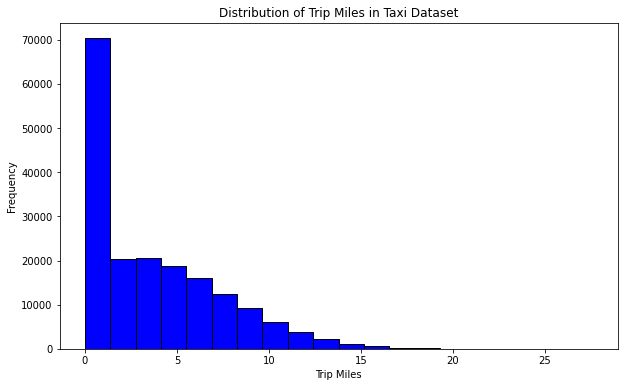

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(par_taxi['trip_miles'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Trip Miles')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Miles in Taxi Dataset')
plt.show()

In [72]:
taxi_df['trip_miles'].mean()

3.2761273737146297

In [73]:
par_taxi['trip_miles'].mean()

3.646291399814507

In [74]:
dgan_taxi['trip_miles'].mean()

0.80665148627714

In [ ]:
filled_taxi_df = taxi_df['trip_miles'].fillna(0)

# Now perform the check
result = all(filled_taxi_df < 456)
print(result)


In [34]:
# Assuming df is your DataFrame and trip_start_timestamp and trip_end_timestamp are your columns
par_taxi['trip_start_timestamp'] = pd.to_datetime(par_taxi['trip_start_timestamp'], errors='coerce')
par_taxi['trip_end_timestamp'] = pd.to_datetime(par_taxi['trip_end_timestamp'], errors='coerce')

# Drop rows where either start or end timestamp couldn't be parsed
par_taxi.dropna(subset=['trip_start_timestamp', 'trip_end_timestamp'], inplace=True)

# Create a mask for rows where the trip start time is not before the trip end time
inconsistent_rows_mask = par_taxi['trip_start_timestamp'] > par_taxi['trip_end_timestamp']

# Use the mask to filter and list the inconsistent rows
inconsistent_rows = par_taxi[inconsistent_rows_mask]

# Display the inconsistent rows
print(inconsistent_rows)

        taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  \
20      71724.0  2016-11-10 09:32:46 2016-11-06 19:02:55         552.0   
22      71724.0  2016-11-12 00:57:46 2016-11-11 00:31:16         795.0   
23      71724.0  2016-11-11 22:33:18 2016-11-11 14:55:39           0.0   
28      71724.0  2016-11-12 04:09:02 2016-11-11 04:43:10           0.0   
39      71724.0  2016-11-13 16:05:22 2016-11-11 08:53:33        1496.0   
...         ...                  ...                 ...           ...   
194395  10579.0  2016-11-27 12:52:41 2016-11-23 01:37:34        1096.0   
194396  10579.0  2016-11-27 20:18:05 2016-11-20 01:52:16        1646.0   
194397  10579.0  2016-11-28 19:31:36 2016-11-12 03:13:43           0.0   
194398  10579.0  2016-11-29 04:46:01 2016-11-15 16:04:20        1422.0   
194399  10579.0  2016-11-29 12:50:11 2016-11-14 16:58:16           0.0   

        trip_miles  pickup_census_tract  dropoff_census_tract  \
20            3.66                  NaN       

In [35]:
# Assuming df is your DataFrame and trip_start_timestamp and trip_end_timestamp are your columns
dgan_taxi['trip_start_timestamp'] = pd.to_datetime(dgan_taxi['trip_start_timestamp'], errors='coerce')
dgan_taxi['trip_end_timestamp'] = pd.to_datetime(dgan_taxi['trip_end_timestamp'], errors='coerce')

# Drop rows where either start or end timestamp couldn't be parsed
par_taxi.dropna(subset=['trip_start_timestamp', 'trip_end_timestamp'], inplace=True)

# Create a mask for rows where the trip start time is not before the trip end time
inconsistent_rows_mask = dgan_taxi['trip_start_timestamp'] > dgan_taxi['trip_end_timestamp']

# Use the mask to filter and list the inconsistent rows
inconsistent_rows = dgan_taxi[inconsistent_rows_mask]

# Display the inconsistent rows
print(inconsistent_rows)

        taxi_id trip_start_timestamp  trip_end_timestamp  trip_seconds  \
1             0  2016-11-10 10:30:00 2016-11-06 01:15:00     99.414673   
3             0  2016-11-10 15:00:00 2016-11-06 01:15:00     98.994133   
5             0  2016-11-10 17:45:00 2016-11-06 01:15:00    368.341919   
11            0  2016-11-12 15:00:00 2016-11-04 14:45:00    358.814819   
12            0  2016-11-12 16:00:00 2016-11-06 01:15:00    105.127670   
...         ...                  ...                 ...           ...   
194391     2159  2016-11-08 15:45:00 2016-11-06 01:15:00    108.545250   
194392     2159  2016-11-08 16:30:00 2016-11-06 01:15:00    107.582031   
194394     2159  2016-11-09 08:00:00 2016-11-06 01:15:00    149.652771   
194396     2159  2016-11-09 08:15:00 2016-11-06 01:15:00    114.309685   
194397     2159  2016-11-09 08:30:00 2016-11-06 01:15:00    267.662689   

        trip_miles  pickup_census_tract  dropoff_census_tract  \
1         1.352318                  0.0       